# **Getting Started Code For [Data Sprint #35](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/overview/about) on DPhi**

## Download the images
We are given google drive link in the '[Data](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/data)' section of problem page which has all the required train images (to build the model) and test images to predict the label of these images and submit the predictions on the [DPhi platform](https://dphi.tech/challenges/data-sprint-35-osteoarthritis-knee-x-ray/81/overview/about).

We can use **GoogleDriveDownloader** form **google_drive_downloader** library in Python to download the shared files from the shared Google drive link: https://drive.google.com/file/d/1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC/view?usp=sharing

The file id in the above link is: **1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC**

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1NdDqPK4NLn2aV8ZdF5ilux1sfG6IyebC',
                                    dest_path='content/KneeXray.zip',
                                    unzip=True)

Unzipping...Done.


We have all the files from the shared Google drive link downloaded in the colab environment.

## Loading Libraries
All Python capabilities are not loaded to our working environment by default (even they are already installed in your system). So, we import each and every library that we want to use.

We chose alias names for our libraries for the sake of our convenience (numpy --> np and pandas --> pd, tensorlow --> tf).

Note: You can import all the libraries that you think will be required or can import it as you go along.

In [3]:
import pandas as pd                                     # Data analysis and manipultion tool
import numpy as np                                      # Fundamental package for linear algebra and multidimensional arrays
import tensorflow as tf                                 # Deep Learning Tool
import os                                               # OS module in Python provides a way of using operating system dependent functionality
import cv2                                              # Library for image processing
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set
from sklearn.metrics import f1_score

## Loading and preparing training data
The train and test images are given in two different folders - 'train' and 'test'. The labels of train images are given in a csv file 'Train.csv' with respective image id (i.e. image file name).

In [4]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import warnings
warnings.filterwarnings('ignore')

In [5]:
#training data direcotry 

training_dir = '/content/content/KneeXray/train'
testing_dir= '/content/content/KneeXray/test'
BATCH_SIZE = 32

#### Getting the labels of the images

In [6]:
train = pd.read_csv("/content/content/KneeXray/Train.csv")   # loading the labels
train.head()           # will display the first five rows in labels dataframe

,filename,label
0,Image_1.jpg,0
1,Image_2.jpg,1
2,Image_3.jpg,0
3,Image_4.jpg,1
4,Image_5.jpg,2


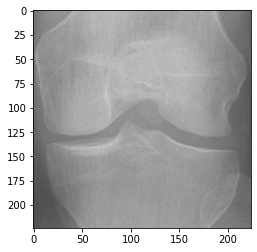

In [7]:
img = cv2.imread('/content/content/KneeXray/train/Image_1.jpg')
plt.imshow(img)

In [8]:
img.shape

(224, 224, 3)

#### Getting images file path

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [10]:
train['label'] = train['label'].astype(str)
train_gen = train_datagen.flow_from_dataframe(
    train,
    directory = training_dir,
    subset='training',
    x_col = 'filename',
    y_col = 'label',
    target_size=(224,224),
    class_mode='categorical'
)

Found 6654 validated image filenames belonging to 5 classes.


In [11]:
val_generator = train_datagen.flow_from_dataframe(
    train,
    directory = training_dir,
    subset = 'validation',
    x_col = 'filename',
    y_col = 'label',
    target_size = (224,224),
    class_mode = 'categorical'
)

Found 1174 validated image filenames belonging to 5 classes.


In [12]:
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile,DenseNet169,DenseNet121
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.regularizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D

In [13]:
resnet= Xception(weights="imagenet",)
x=resnet.layers[-2].output
fc1=Dense(5,activation='softmax',kernel_initializer='glorot_uniform')(x)
my_model=Model(inputs=resnet.input,outputs=fc1)

91889664/91884032 [==============================] - 3s 0us/step


In [14]:
STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

In [15]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics=['accuracy'],
                 loss= tf.keras.losses.CategoricalCrossentropy())

In [16]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
ModelCheckpoint(checkpoint_path, monitor = 'accuracy',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)]

In [17]:
my_model.fit(
train_gen,
steps_per_epoch=STEP_SIZE_TRAIN,
epochs=40,
validation_data=val_generator,
validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/40
207/207 [==============================] - 346s 1s/step - loss: 1.1274 - accuracy: 0.5239 - val_loss: 0.9393 - val_accuracy: 0.5990

Epoch 00001: accuracy improved from -inf to 0.52386, saving model to training_0/cp.ckpt
Epoch 2/40
207/207 [==============================] - 305s 1s/step - loss: 0.8613 - accuracy: 0.6321 - val_loss: 0.8839 - val_accuracy: 0.6311

Epoch 00002: accuracy improved from 0.52386 to 0.63214, saving model to training_0/cp.ckpt
Epoch 3/40
207/207 [==============================] - 305s 1s/step - loss: 0.7752 - accuracy: 0.6731 - val_loss: 0.8006 - val_accuracy: 0.6528

Epoch 00003: accuracy improved from 0.63214 to 0.67306, saving model to training_0/cp.ckpt
Epoch 4/40
207/207 [==============================] - 305s 1s/step - loss: 0.6866 - accuracy: 0.7122 - val_loss: 0.8363 - val_accuracy: 0.6632

Epoch 00004: accuracy improved from 0.67306 to 0.71217, saving model to training_0/cp.ckpt
Epoch 5/40
207/207 [==============================] - 305s 1s/s

In [18]:
my_model.save_weights("Xceptionnet.h5")

In [19]:
my_model.evaluate(val_generator,verbose=1)

37/37 [==============================] - 19s 512ms/step - loss: 0.9427 - accuracy: 0.6627


[0.9426553249359131, 0.6626916527748108]

In [20]:
test = pd.read_csv('/content/content/KneeXray/Test.csv')

In [21]:
test.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [22]:
test_generator=train_datagen.flow_from_dataframe(
dataframe=test,
directory=testing_dir,
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1958 validated image filenames.


In [23]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

1958/1958 [==============================] - 39s 19ms/step


In [24]:
pred1

array([2, 0, 0, ..., 0, 3, 0])

In [25]:
sub=pd.read_csv("/content/content/KneeXray/sample_submission.csv")
sub["label"]=pred1

In [26]:
sub["label"].value_counts()

0    834
2    681
3    279
4     82
1     82
Name: label, dtype: int64

In [27]:
sub.to_csv("sub2.csv",index=False)